# Autoencoder
- MNIST
- Neural Network
- 1 hidden layers

In [ ]:
!pip install torch torchvision

## 1. Settings
### 1) Import required libraries

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt

### 2) Set hyperparameters

In [ ]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 5

## 2. Data

### 1) Download Data

In [ ]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 113627126.95it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 78202513.77it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42311192.80it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15757261.18it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



### 2) Set DataLoader

In [ ]:
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

In [ ]:
train_loader

## 4. Model & Optimizer
### 1) Model

In [ ]:
# 인공신경망으로 이루어진 오토엔코더를 생성합니다.
# 단순하게 하기 위해 활성화 함수는 생략했습니다.
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(28*28, 20)
        self.decoder = nn.Linear(20, 28*28)

    def forward(self, x):
        x = x.view(batch_size,-1)
        encoded = self.encoder(x)
        out = self.decoder(encoded).view(batch_size,1,28,28)
        return out

### 2) Loss func & Optimizer

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

cuda:0


## 5. Train

In [ ]:
loss_arr =[]
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,x)
        loss.backward()
        optimizer.step()

    if j % 1000 == 0:
        print(loss)
        loss_arr.append(loss.cpu().data.numpy()[0])

## 6. Check with Train Image

torch.Size([256, 28, 28])


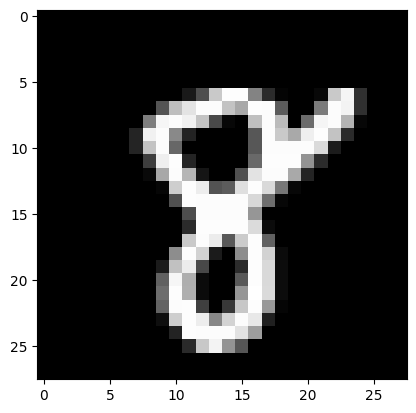

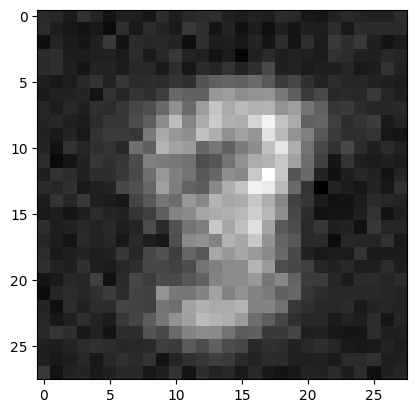

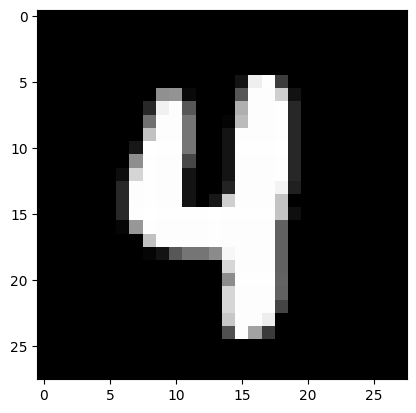

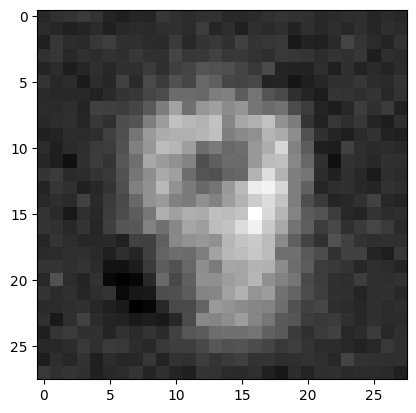

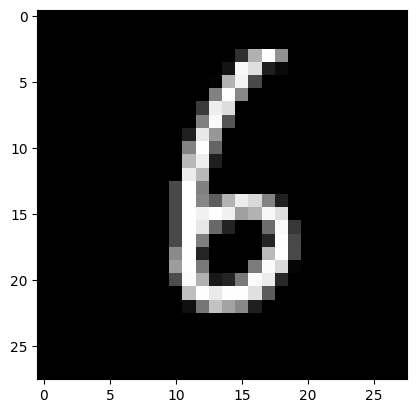

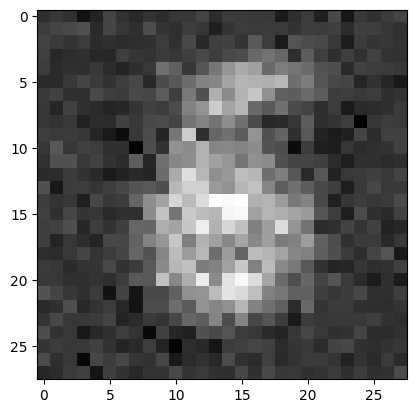

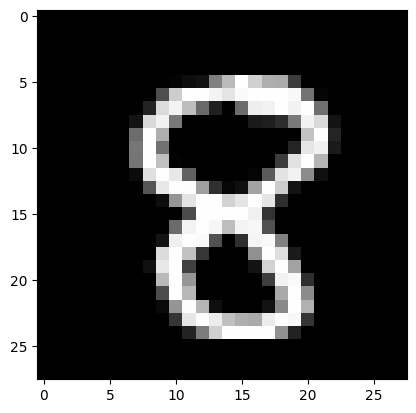

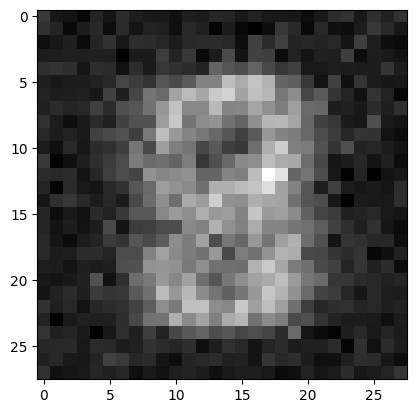

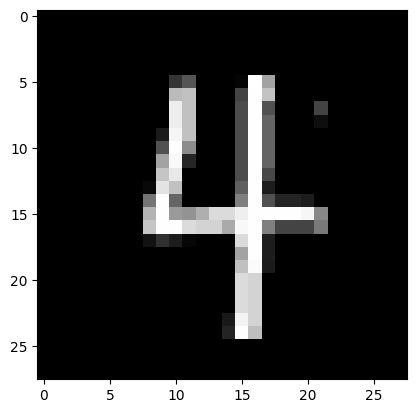

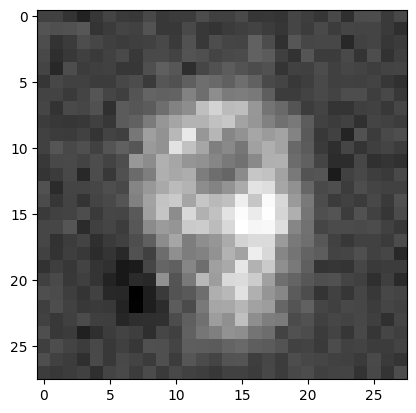

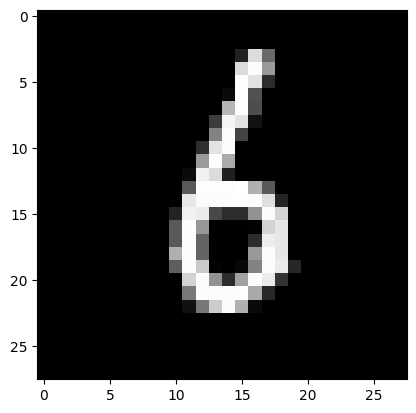

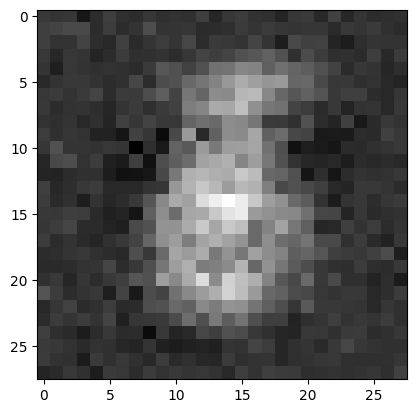

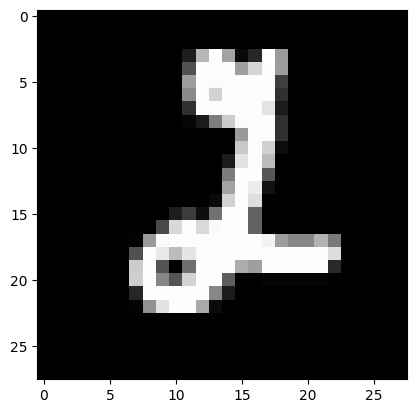

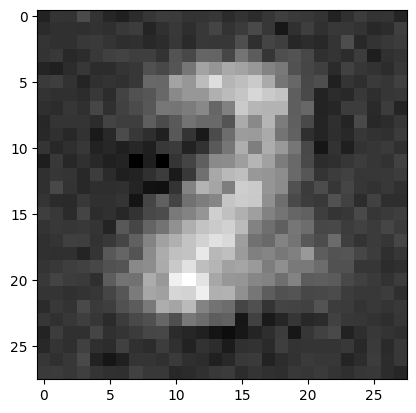

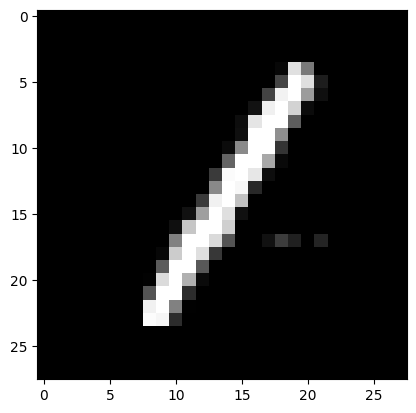

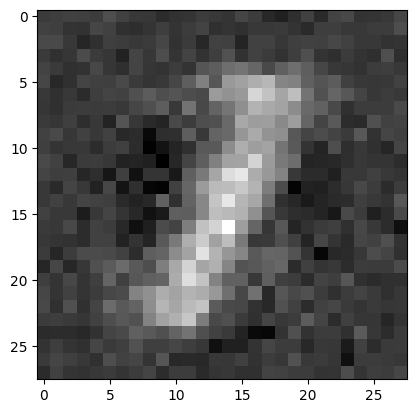

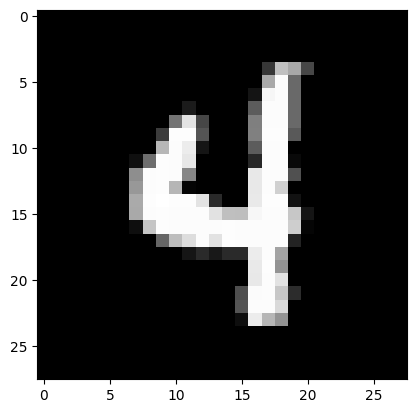

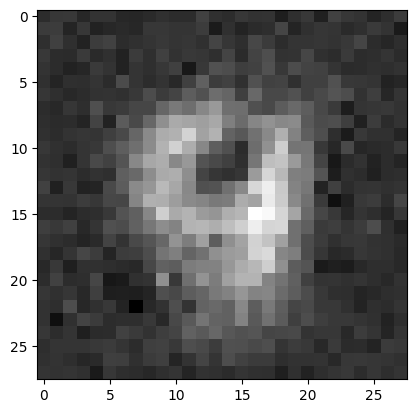

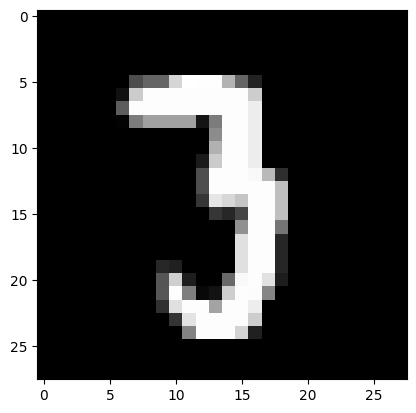

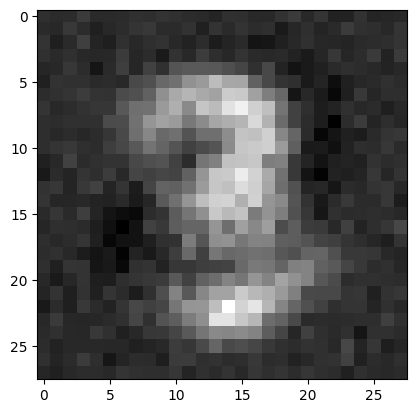

In [ ]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(10):
    plt.imshow(torch.squeeze(image[i]).numpy(),cmap='gray')
    plt.show()
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

# Convolutional Autoencoder
- MNIST dataset
- Convolutional Neural Network
- 2 hidden layers

In [ ]:
!pip install torch torchvision

## 1. Settings
### 1) Import required libraries

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

### 2) Set hyperparameters

In [ ]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 5

## 2. Data

### 1) Download Data

In [ ]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

### 2) Set DataLoader

In [ ]:
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

## 4. Model & Optimizer
### 1) Model

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1, 16, 3, padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16, 32, 3, padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32, 64, 3, padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)
        )

        self.layer2 = nn.Sequential(
                        nn.Conv2d(64, 128, 3, padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128, 256, 3, padding=1),
                        nn.ReLU()
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out



In [ ]:
from torch.ao.nn.quantized.modules.batchnorm import BatchNorm2d
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128, 64, 3, 1, 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64, 16, 3, 1, 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16, 1, 3, 2, 1, 1),
                        nn.ReLU()
        )

    def forward(self,x):
        out = x.view(batch_size,256,7,7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

### 2) Loss func & Optimizer

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

# 인코더 디코더의 파라미터를 동시에 학습시키기 위해 이를 묶는 방법입니다.
parameters = list(encoder.parameters())+ list(decoder.parameters())

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

cuda:0


## 5. Train

In [ ]:
# 모델을 불러오는 방법입니다.
# 크게 두가지 방법이 있는데 여기 사용된 방법은 좀 단순한 방법입니다.
# https://pytorch.org/tutorials/beginner/saving_loading_models.html

try:
    encoder, decoder = torch.load('./model/conv_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        optimizer.zero_grad()
        image = image.to(device)

        output = encoder(image)
        output = decoder(output)

        loss = loss_func(output, image)
        loss.backward()
        optimizer.step()

    if j % 10 == 0:
        # 모델 저장하는 방법
        # 이 역시 크게 두가지 방법이 있는데 여기 사용된 방법은 좀 단순한 방법입니다.
        # https://pytorch.org/tutorials/beginner/saving_loading_models.html
        torch.save([encoder,decoder],'./model/conv_autoencoder.pkl')
        print(loss)



--------model not restored--------



## 6. Check with Train Image

torch.Size([256, 28, 28])


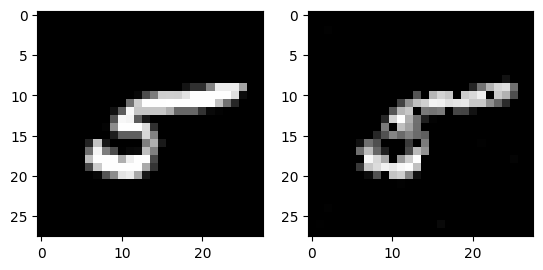

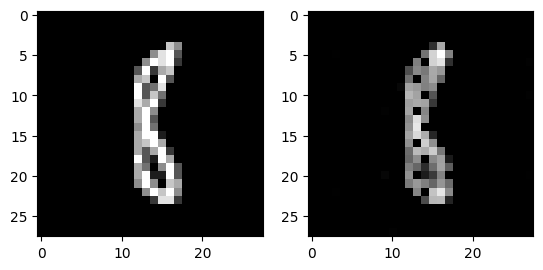

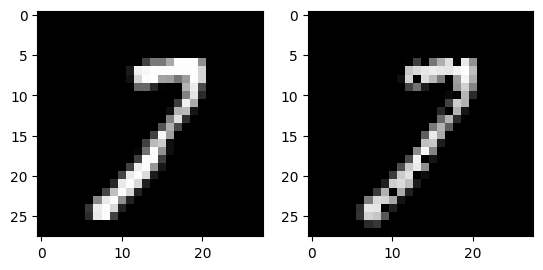

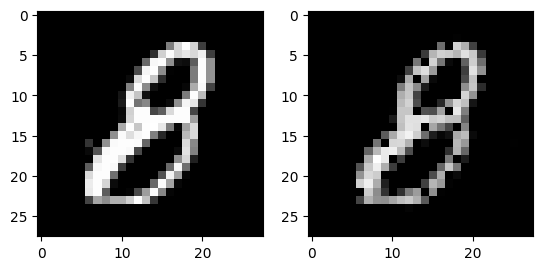

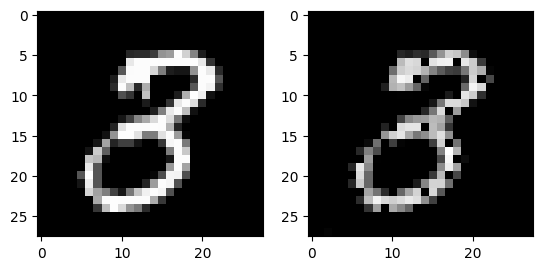

In [ ]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

In [ ]:
with torch.no_grad():
    for j,[image,label] in enumerate(test_loader):

        image = image.to(device)
        output = encoder(image)
        output = decoder(output)

    if j % 10 == 0:
        print(loss)

torch.Size([256, 28, 28])


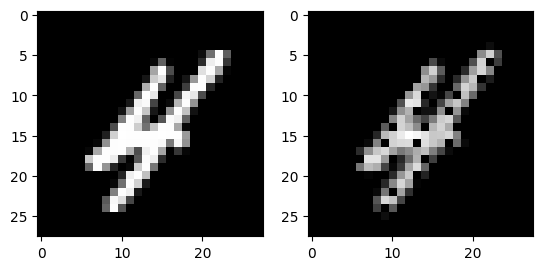

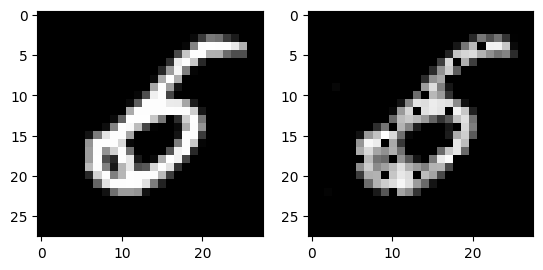

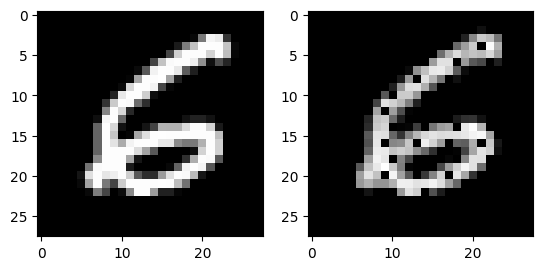

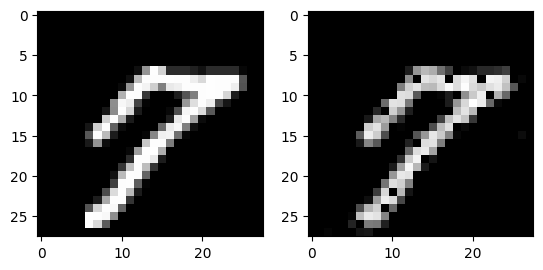

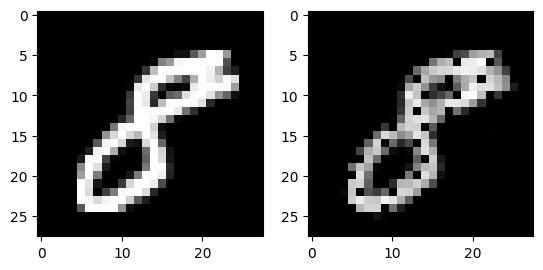

In [ ]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

# U-Net Architecture

![대체 텍스트](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [ ]:
import torch.nn as nn
import torch
import torch.utils as utils
import torch.nn.init as init
import torch.utils.data as data
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [ ]:
# 자주 쓰는 연산들과 항상 세트로 쓰는 연산들은 편의를 위해 함수로 정의해 놓습니다.

def conv_block(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def conv_trans_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim,out_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool

def conv_block_2(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        conv_block(in_dim,out_dim,act_fn),
        nn.Conv2d(out_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model

In [ ]:
class UnetGenerator(nn.Module):
    def __init__(self,in_dim,out_dim,num_filter):
        super(UnetGenerator,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)

        print("\n------Initiating U-Net------\n")

        self.down_1 = conv_block_2(self.in_dim,self.num_filter,act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter*1,self.num_filter*2,act_fn)
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter*2,self.num_filter*4,act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter*4,self.num_filter*8,act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter*8,self.num_filter*16,act_fn)

        self.trans_1 = conv_trans_block(self.num_filter*16,self.num_filter*8,act_fn)
        self.up_1 = conv_block_2(self.num_filter*16,self.num_filter*8,act_fn)
        self.trans_2 = conv_trans_block(self.num_filter*8,self.num_filter*4,act_fn)
        self.up_2 = conv_block_2(self.num_filter*8,self.num_filter*4,act_fn)
        self.trans_3 = conv_trans_block(self.num_filter*4,self.num_filter*2,act_fn)
        self.up_3 = conv_block_2(self.num_filter*4,self.num_filter*2,act_fn)
        self.trans_4 = conv_trans_block(self.num_filter*2,self.num_filter*1,act_fn)
        self.up_4 = conv_block_2(self.num_filter*2,self.num_filter*1,act_fn)

        self.out = nn.Sequential(
            nn.Conv2d(self.num_filter,self.out_dim,3,1,1),
            nn.Tanh(),  #필수는 아님
        )

    def forward(self,input):
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)
        concat_1 = torch.cat([trans_1,down_4],dim=1)
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = torch.cat([trans_2,down_3],dim=1)
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = torch.cat([trans_3,down_2],dim=1)
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = torch.cat([trans_4,down_1],dim=1)
        up_4 = self.up_4(concat_4)
        out = self.out(up_4)
        return out

In [ ]:
batch_size = 16
img_size = 256
in_dim = 1
out_dim = 3
num_filters = 16

sample_input = torch.ones(size=(batch_size,1,img_size,img_size))

In [ ]:
sample_input.shape

torch.Size([16, 1, 256, 256])

In [ ]:
model = UnetGenerator(in_dim=in_dim,out_dim=out_dim,num_filter=num_filters)
output = model(sample_input)
print(output.size())


------Initiating U-Net------

torch.Size([16, 3, 256, 256])


오늘의 실습 내용: </br>
1. 강의 자료 내용 ( MNIST, U-Net ) 코드 적용 / 실행 </br>
2. 지난 주 내용( custom dataset ) 오토인코더 적용 (데이터셋 연동까지만. 학습은 수렴하지 않아도 됨)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/영상처리와딥러닝/week11/dataset/

/content/drive/MyDrive/Colab Notebooks/영상처리와딥러닝/week11/dataset


In [ ]:
ls

chicken/  hambuger/  pasta/  pizza/


In [ ]:
import os
from glob import glob
import pandas as pd

In [ ]:
file_path = '/content/drive/MyDrive/dataset/*/*.jpg'

file_list = glob(file_path)
file_list

['/content/drive/MyDrive/dataset/pizza/pizza-01.jpg',
 '/content/drive/MyDrive/dataset/pizza/pizza-10.jpg',
 '/content/drive/MyDrive/dataset/pizza/pizza-08.jpg',
 '/content/drive/MyDrive/dataset/pizza/pizza-04.jpg',
 '/content/drive/MyDrive/dataset/pizza/pizza-07.jpg',
 '/content/drive/MyDrive/dataset/pizza/pizza-03.jpg',
 '/content/drive/MyDrive/dataset/pizza/pizza-02.jpg',
 '/content/drive/MyDrive/dataset/pizza/pizza-06.jpg',
 '/content/drive/MyDrive/dataset/pizza/pizza-09.jpg',
 '/content/drive/MyDrive/dataset/pizza/pizza-05.jpg',
 '/content/drive/MyDrive/dataset/pasta/pasta-10.jpg',
 '/content/drive/MyDrive/dataset/pasta/pasta-09.jpg',
 '/content/drive/MyDrive/dataset/pasta/pasta-08.jpg',
 '/content/drive/MyDrive/dataset/pasta/pasta-01.jpg',
 '/content/drive/MyDrive/dataset/pasta/pasta-06.jpg',
 '/content/drive/MyDrive/dataset/pasta/pasta-05.jpg',
 '/content/drive/MyDrive/dataset/pasta/pasta-02.jpg',
 '/content/drive/MyDrive/dataset/pasta/pasta-07.jpg',
 '/content/drive/MyDrive/dat

In [ ]:
data_dict = {'image_name':[], 'class':[], 'target':[], 'file_path':[]}
target_dict = {'chicken':0, 'hambuger':1, 'pasta':2, 'pizza':3}

for path in file_list:

    data_dict['file_path'].append(path) # file_path 항목에 파일 경로 저장

    path_list = path.split(os.path.sep) # os별 파일 경로 구분 문자로 split
    print(path_list)

    data_dict['image_name'].append(path_list[-1])
    data_dict['class'].append(path_list[-2])
    data_dict['target'].append(target_dict[path_list[-2]])

train_df = pd.DataFrame(data_dict)
print('\n<data frame>\n', train_df)

train_df.to_csv("/content/drive/MyDrive/dataset/train.csv", mode='w')

['', 'content', 'drive', 'MyDrive', 'dataset', 'pizza', 'pizza-01.jpg']
['', 'content', 'drive', 'MyDrive', 'dataset', 'pizza', 'pizza-10.jpg']
['', 'content', 'drive', 'MyDrive', 'dataset', 'pizza', 'pizza-08.jpg']
['', 'content', 'drive', 'MyDrive', 'dataset', 'pizza', 'pizza-04.jpg']
['', 'content', 'drive', 'MyDrive', 'dataset', 'pizza', 'pizza-07.jpg']
['', 'content', 'drive', 'MyDrive', 'dataset', 'pizza', 'pizza-03.jpg']
['', 'content', 'drive', 'MyDrive', 'dataset', 'pizza', 'pizza-02.jpg']
['', 'content', 'drive', 'MyDrive', 'dataset', 'pizza', 'pizza-06.jpg']
['', 'content', 'drive', 'MyDrive', 'dataset', 'pizza', 'pizza-09.jpg']
['', 'content', 'drive', 'MyDrive', 'dataset', 'pizza', 'pizza-05.jpg']
['', 'content', 'drive', 'MyDrive', 'dataset', 'pasta', 'pasta-10.jpg']
['', 'content', 'drive', 'MyDrive', 'dataset', 'pasta', 'pasta-09.jpg']
['', 'content', 'drive', 'MyDrive', 'dataset', 'pasta', 'pasta-08.jpg']
['', 'content', 'drive', 'MyDrive', 'dataset', 'pasta', 'pasta-0

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/train.csv')

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class Classification_Dataset(Dataset):
    def __init__(self, csv, mode, transform=None):
        self.csv = csv.reset_index(drop=True)  # random으로 섞인 데이터의 인덱스를 reset 시켜서 다시 부여한다.
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0]  # csv 파일의 행 개수 == 데이터 개수

    def __getitem__(self, index):
        row = self.csv.iloc[index]                       # 주어진 index에 대한 데이터 뽑아오기
        image = Image.open(row.file_path).convert('RGB') # 파일경로로 부터 이미지를 읽고 rgb로 변환하기

        if self.transform:
            image = self.transform(image) # 이미지에 transform 적용하기

        return image # 이미지 return하기

In [ ]:
dataset_df = Classification_Dataset(df, 'train', transform=transforms.ToTensor())

In [ ]:
print(dataset_df.__getitem__(39).shape)

torch.Size([3, 182, 276])




데이터 파일 같은 크기로 바꿔주기

In [ ]:
from torchvision import transforms

def get_transforms(image_size):

    transforms_train = transforms.Compose([
                                       transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(image_size),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.7669051, 0.65760386, 0.5565754],
                                                            [0.04530642, 0.041517295, 0.064540155])])


    return transforms_train

In [ ]:
transforms_train = get_transforms(256)
dataset_train = Classification_Dataset(df, 'train', transform=transforms_train)
dataset_train.__getitem__(3).shape

torch.Size([3, 256, 256])

In [ ]:
from torch.utils.data.sampler import RandomSampler
from torch.utils.data import DataLoader

practice_data = torch.utils.data.DataLoader(dataset_train, batch_size=256, sampler=RandomSampler(dataset_train), num_workers=0)

In [ ]:
for images in practice_data:
    print(f'[batch, channel, ...] : {images.shape}')

[batch, channel, ...] : torch.Size([40, 3, 256, 256])


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [ ]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 5

In [ ]:
loss_arr =[]
for i in range(num_epoch):
    for j,[image,label] in enumerate(practice_data):
        x = image.to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,x)
        loss.backward()
        optimizer.step()

    print(loss)
    loss_arr.append(loss.cpu().data.numpy()[0])

ValueError: ignored